<h1>Equity Fund Strategy Analysis<h1>
<h2>Introduction</h2>
<article>
This Notebook shows example of how one could approach a style analysis of a group of hedge funds.
It's not meant to provide a complete analysis but rather serve as example of what a complete analysis would entail. For confidentiality reasons fund names are masked as fund ids. No cleansing of data was performed other than to identify a list of equity focused hedge funds (self classified) that have a relatively long track record. 

This example uses Principal Component Analysis (PCA) approach for constructing peer groups of hedge funds. 
</article>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h2>Data</h2>
<article>
Market data for risk factors is contained in factormodeldata.csv while the fund time series is stored in eqlsts.csv
</article>

In [3]:
#read all data
marketdata = pd.DataFrame.from_csv("data/factormodeldata.csv")
ts = pd.DataFrame.from_csv("data/eqlsts.csv")
#fund covariance matrix
cv = ts.cov()
#fund correlation matrix
cr = ts.corr()
regdata = pd.concat([ts,marketdata],join='inner',axis=1)
cvregdata = regdata.cov()

<H2>Diversification</H2>
<article>First step in this process is identification of principal components (PC). We calculate PCs based on covariance of the funds' time series. 
</article>

In [5]:
#Calculate Eigen Values
eigval,eigvec = np.linalg.eig(cv)
N = len(eigval)

#sort eigen values/vector tuples by eigen values in decreasing order. 
eigxy = [(eigval[i],eigvec[:,i]) for i in range(N)]
eigxy.sort()
eigxy.reverse()


#total variance of the system as the sum of eigen values
totvar = np.array(eigval).sum()

#The universe is too large. Chances are we don't need to use all 367 components.
#So we limit our analysis to the first 20
eigxy = eigxy[:20]
key = np.array([e[0] for e in eigxy])
pctvar = key.cumsum()/totvar

In [9]:
<h3>Plot Eigen Values</H3>

SyntaxError: invalid syntax (<ipython-input-9-b21864737b32>, line 1)

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/matplotlib/patches.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
/Users/Aleksey/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


'We need 11 factors to explain 80% of variation among 367 funds'

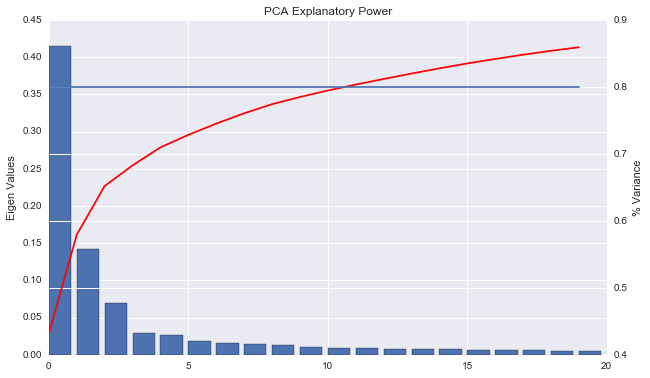

In [8]:
#Plot PCAs to see how many factors we need to classify funds
fig,ax1 = plt.subplots(figsize=(10,6))
ax1.bar(np.arange(20),key)
ax2 = ax1.twinx()
ax2.plot(pctvar,'r')
ax2.plot(np.ones(20)*0.8)
plt.title('PCA Explanatory Power')
ax1.set_ylabel('Eigen Values')
ax2.set_ylabel('% Variance')
K = np.argmax(pctvar >= 0.8)
eigvec = eigvec[:,0:K]
str.format("We need {0} factors to explain 80% of variation among {1} funds", K,N)

<h2>Interpreting the Factors</h2>
<article>
We now try to interpret the factors by finding the market factors that each PC factor has the highest correlation to.
</article>

In [10]:
# Calculate PC Factor Time Series
Mevec = np.matrix(eigvec)
Mts = np.matrix(ts)
Mpcats = Mts * Mevec
pcacols = [str.format("PC{0}",i+1) for i in range(K)]
pcats = pd.DataFrame(Mpcats,index=ts.index,columns=pcacols)
pcaregdata = pd.concat([pcats,marketdata],axis=1,join='inner')
regdatacv = pcaregdata.cov()
MC = np.matrix(regdatacv)
pcacorr =  pcaregdata.corr()

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:4556: ComplexWarning: Casting complex values to real discards the imaginary part
  correl = _algos.nancorr(com._ensure_float64(mat), minp=min_periods)


In [18]:
def CalcBestFit(cr, idx,K,names):
    """
        Find the highest correlated factor
    """
    crcol = cr.iloc[:,idx]
    crtup = list(zip(crcol,names))
    crtup.sort(reverse=True)
    return crtup[1]


We now find the highest correlated factor for each Principal Coponent

In [20]:
bestfits = [CalcBestFit(pcacorr,i,K,pcaregdata.columns) for i in range(K)]
bestfitDF = pd.DataFrame(bestfits,index=pcaregdata.columns[0:K],columns=['Corr','Index'])
bestfitDF

,Corr,Index
PC1,0.936293,NYSE Composite
PC2,0.127503,ML High Yield Master II
PC3,0.378848,AMEX Airline Index
PC4,0.182336,AMEX Select Sector SPIDER - Financial Index
PC5,0.312048,AMEX Dollar Index
PC6,0.241111,CAC 40
PC7,0.351616,S&P GSCI Commodity Index Spot
PC8,0.279125,AMEX North American Telecommunication Index
PC9,0.159716,British Pound
PC10,0.206193,AMEX International Market Index


<H3>PC1</H3>
<p>
As we would expect PC1 represents the general market index. Exposure to this factor is roughly equivalent to market beta. We can therefore separate the funds based on positive (long) and negative (short) exposure to PC1. 
<br/>
One way to group the funds would be by their exposure to this factor. In addition we can assume that the funds for which the first principal component is not a main component have low or no exposure to equity markets and therefore should be considered separately from other Long/Short funds.
</p>
<p>
</p>

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


([<matplotlib.axis.YTick at 0x11ffe04a8>,
 <a list of 10 Text yticklabel objects>)

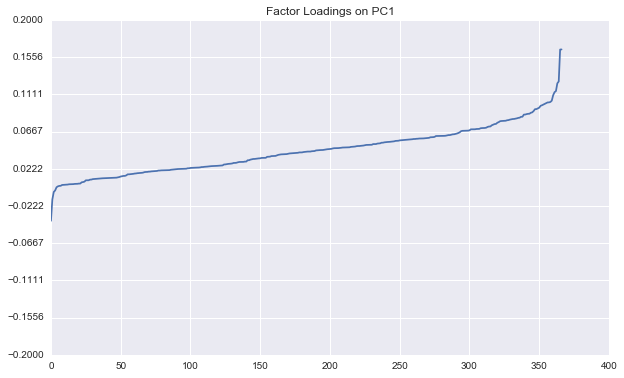

In [24]:
#Plot Loadings onf the first Principal Component - Market Beta
fig,ax1 = plt.subplots(figsize=(10,6))
plt.title('Factor Loadings on PC1')
fundids = ts.columns
pc1funds = list(zip(eigvec[:,0],fundids))
pc1funds.sort()
pc1val,pc1id = zip(*pc1funds)
ax1.plot(pc1val)
plt.yticks(np.linspace(-0.2,0.2,10))

<H3>Interepretation</H3>
<article>Funds on the right have positive market beta. Funds on the left have either short or no exposure to equity markets</article>

<H3>PC2</H3>
<p>
PCA 2 picture is different. The factor is most correlated to Merrill Lynch High Yield Master index, which could represent credit exposure. However, the correlation is low: 12.7%
<br>
When we plot PCA factor loadings one fund stads out:
</p>

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


([<matplotlib.axis.YTick at 0x120a94c88>,
 <a list of 10 Text yticklabel objects>)

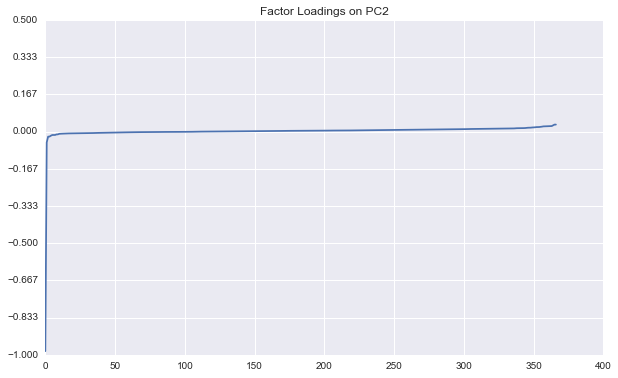

In [27]:
#Plot PCAs to see how many factors we need to classify funds
fig,ax1 = plt.subplots(figsize=(10,6))

plt.title('Factor Loadings on PC2')
fundids = ts.columns
pc2funds = list(zip(eigvec[:,1],fundids))
pc2funds.sort()
pc2val,pc2id = zip(*pc2funds)
ax1.plot(pc2val)
plt.yticks(np.linspace(-1,0.5,10))

From the description of the fund that stands out we notice that the fund invests in structured transactions involving Russian gas and oil companies. The strategy is certainly unique as we can see by the fund's average correlations to other funds 

In [28]:
fundid = pc2funds[0][1]
fundcorrs = cr[fundid]
avgcorr = (fundcorrs.sum() - 1)/(len(fundcorrs)-1)
str.format("The fund has average correlation to other funds in our list of only {0:0.2%}", avgcorr)

'The fund has average correlation to other funds in our list of only 9.58%'

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


([<matplotlib.axis.YTick at 0x1207d88d0>,
 <a list of 10 Text yticklabel objects>)

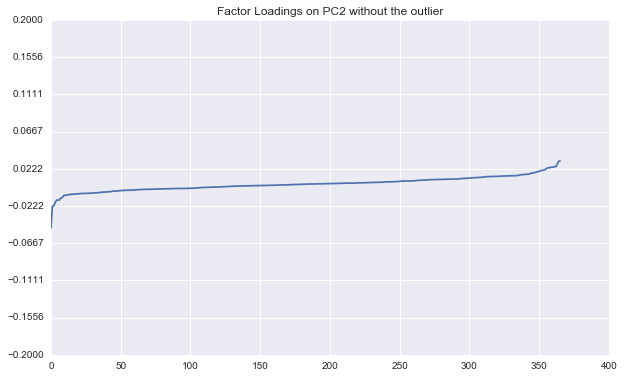

In [30]:
#Plot PCAs to see how many factors we need to classify funds
fig,ax1 = plt.subplots(figsize=(10,6))
plt.title('Factor Loadings on PC2 without the outlier')
ax1.plot(pc2val[1:])
plt.yticks(np.linspace(-0.2,0.2,10))

We notice a much narrower range of loading to the factor

<h2>Grouping funds by PCA loading</h2>
<article>
We can do initial grouping of funds based on which factor has the highest loading for each fund. This can serve as starting point in further classifying funds.</article>

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  app.launch_new_instance()


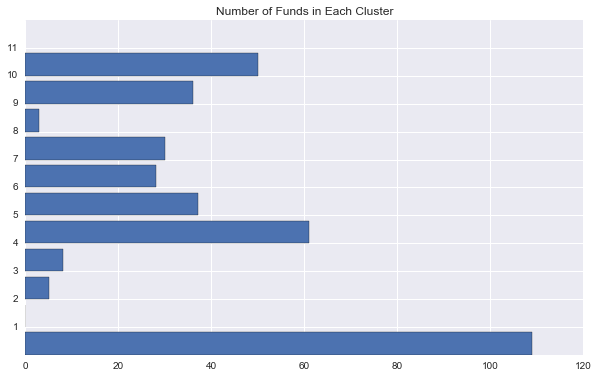

In [33]:
eigvecdf = pd.DataFrame(eigvec,index=fundids)
fundidx = np.array(fundids)
x = np.array([np.argmax(eigvecdf.irow(i)) for i in range(367)])
groups = [(i,fundidx[x == i]) for i in range(K)]
groupCount = [len(g[1]) for g in groups]
fig,ax1 = plt.subplots(figsize=(10,6))
ax1.barh(np.arange(K),groupCount)
plt.yticks(np.arange(K)+1)
plt.title('Number of Funds in Each Cluster')

<H2>Examining Initial Clusters</H2>
<p>
We start by visualizing correlations among the funds in each cluster.
</p>

In [89]:

def plotCorrMatrix(tsall, groups, idx,showcorr):
    """
        Function to plot correlation matrix based on a group/cluster
    """
    group = groups[idx]
    ids = list(group[1])
    fig,ax1 = plt.subplots(figsize=(15,15))
    if (len(ids) > 2):
        tsi = tsall[ids]
        
        corr = tsi.corr()
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
        
      
        plt.title(str.format("Cluster {0}",idx+1))

Let's initially skip Cluster 1 since it has the most number of funds and examine smaller clusters first
<H3>Cluster 2</H3>
Cluster 2 contains only one fund. So there is no correlation matrix to examine. Further analysis of this one fund would be warranted
<h3>
Clusters 3 & 4</H3>


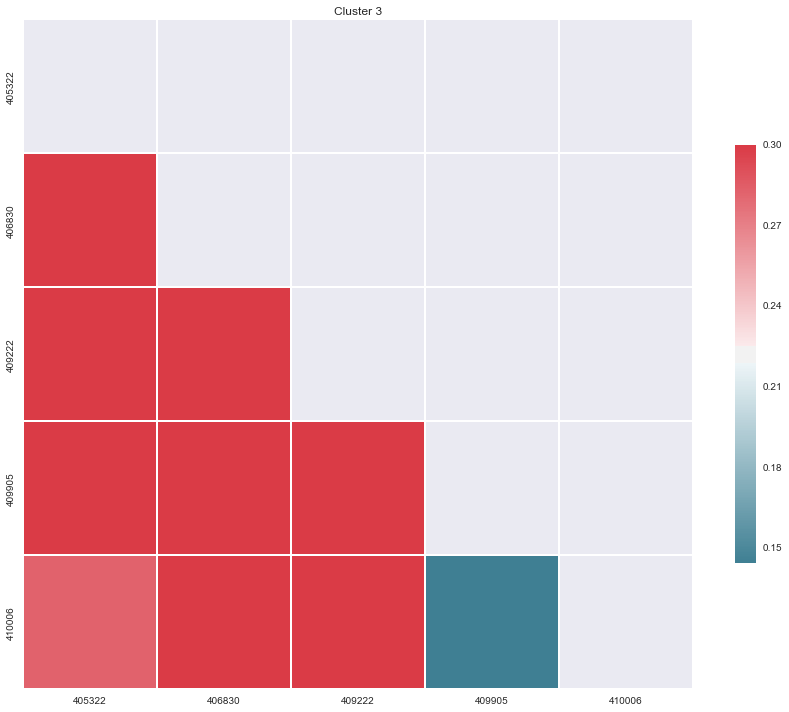

In [90]:
plotCorrMatrix(ts,groups,2,True)


One fund clearly doesn't seem to belong to this cluster. 

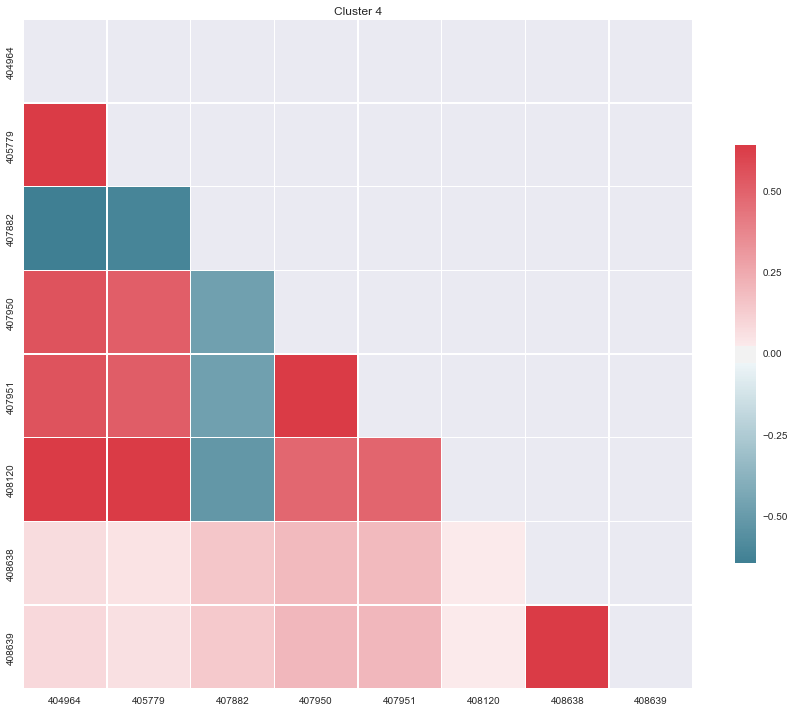

In [91]:
plotCorrMatrix(ts,groups,3,True)

The sector does not seem very uniform wih correlation ranging from -0.5 to  0.5

<H3>Cluster 1</H3>

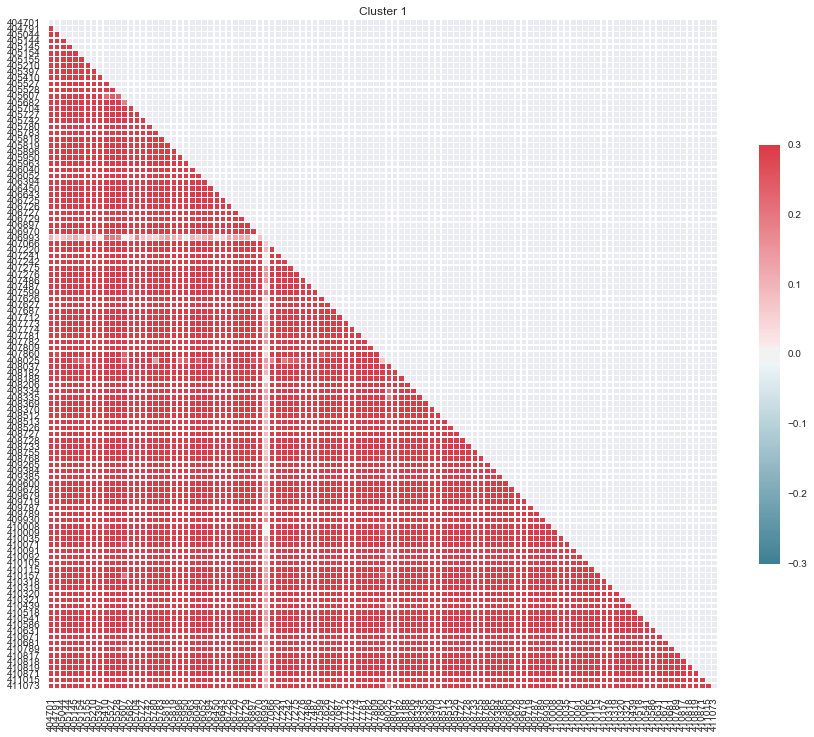

In [92]:

plotCorrMatrix(ts,groups,0,False)

Again the cluster is not very uniform. With so many funds there is definitely a need to drill down further.